# Single-Cell Differential Expression with edgePython: *Clytia hemisphaerica*

This notebook demonstrates **single-cell differential expression analysis** using edgePython's NEBULA-LN negative binomial mixed model with empirical Bayes dispersion shrinkage.

## Dataset

Single-cell RNA-seq of the jellyfish *Clytia hemisphaerica* from [Chari et al. (2021)](https://doi.org/10.1016/j.celrep.2021.109751). The experiment compares **fed** vs **starved** animals across 10 organisms (5 per condition). We focus on 2,564 gastrodigestive cells.

Data obtained from [CaltechDATA (accession mm6y6-g4569)](https://data.caltech.edu/records/mm6y6-g4569).

## Analysis

The NEBULA-LN mixed model accounts for both biological variation between organisms (random effect) and the fed/starved condition (fixed effect). Empirical Bayes shrinkage stabilizes per-gene dispersion estimates, which is especially important in single-cell data where per-gene sample sizes are small.

This notebook reproduces the panels of Figure 2 from the edgePython paper.

In [1]:
import sys, subprocess

IN_COLAB = 'google.colab' in sys.modules

try:
    import edgepython as ep
except ImportError:
    subprocess.check_call([sys.executable, '-m', 'pip', 'install', '-q', 'edgepython'])
    import edgepython as ep

import os, tempfile, gzip, urllib.request
import numpy as np
import pandas as pd
import h5py
import scipy.sparse as sp
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D

%matplotlib inline

# Download data from CaltechDATA
DATA_URL = 'https://data.caltech.edu/records/mm6y6-g4569/files/fedStarved_withUMAPPaga.h5ad.gz?download=1'
data_dir = tempfile.mkdtemp()
gz_path = os.path.join(data_dir, 'data.h5ad.gz')
h5ad_path = os.path.join(data_dir, 'fedStarved_withUMAPPaga.h5ad')

print('Downloading Clytia scRNA-seq data (491 MB)...', flush=True)
urllib.request.urlretrieve(DATA_URL, gz_path)
print('Decompressing...', flush=True)
with gzip.open(gz_path, 'rb') as f_in:
    with open(h5ad_path, 'wb') as f_out:
        while True:
            chunk = f_in.read(1 << 20)
            if not chunk:
                break
            f_out.write(chunk)
os.remove(gz_path)
print('Download complete.')

# Load via h5py
h5 = h5py.File(h5ad_path, 'r')
raw_data = np.round(np.expm1(h5['raw']['X']['data'][:])).astype(np.float64)
raw_indices = h5['raw']['X']['indices'][:]
raw_indptr = h5['raw']['X']['indptr'][:]
n_obs = len(raw_indptr) - 1
raw_gene_names = np.array([g.decode() for g in h5['raw']['var']['index'][:]])
n_var_raw = len(raw_gene_names)
X_raw = sp.csr_matrix((raw_data, raw_indices, raw_indptr), shape=(n_obs, n_var_raw))

annosSub_cats = [c.decode() for c in h5['obs']['__categories']['annosSub'][:]]
annosSub_codes = h5['obs']['annosSub'][:]
fed_cats = [c.decode() for c in h5['obs']['__categories']['fed'][:]]
fed_codes = h5['obs']['fed'][:]
orgID_cats = [c.decode() for c in h5['obs']['__categories']['orgID'][:]]
orgID_codes = h5['obs']['orgID'][:]
h5.close()

print(f'Full dataset: {n_obs:,} cells x {n_var_raw:,} genes')

Using local data file.
Full dataset: 13,673 cells x 28,514 genes


In [2]:
plt.rcParams.update({
    'figure.dpi': 120, 'font.size': 11, 'axes.titlesize': 13,
    'axes.labelsize': 12, 'xtick.labelsize': 10, 'ytick.labelsize': 10,
    'legend.fontsize': 10, 'figure.figsize': (8, 5),
    'axes.spines.top': False, 'axes.spines.right': False,
})

BLUE = '#4878cf'
ORANGE = '#e8823a'
RED = '#c44e52'
GREY = '#aaaaaa'

## 1. Explore the Dataset

We subset to **gastrodigestive** cells, which are involved in nutrient processing and are expected to show strong fed vs starved transcriptional differences.

In [3]:
# Subset to GastroDigestive cells
gastro_idx = [i for i, c in enumerate(annosSub_cats) if c.startswith('GastroDigestive')]
cell_mask = np.isin(annosSub_codes, gastro_idx)
counts_gastro = X_raw[cell_mask, :]
fed_gastro = np.array([fed_cats[c] for c in fed_codes[cell_mask]])
org_gastro = np.array([orgID_cats[c] for c in orgID_codes[cell_mask]])
subtype_gastro = np.array([annosSub_cats[c] for c in annosSub_codes[cell_mask]])
n_gastro = cell_mask.sum()

print(f'GastroDigestive cells: {n_gastro:,}')
print(f'  Fed: {(fed_gastro == "True").sum():,}')
print(f'  Starved: {(fed_gastro == "False").sum():,}')
print(f'  Organisms: {len(np.unique(org_gastro))}')
print()
print('Cell subtypes:')
for st in sorted(set(subtype_gastro)):
    print(f'  {st}: {(subtype_gastro == st).sum()} cells')

GastroDigestive cells: 2,564
  Fed: 1,316
  Starved: 1,248
  Organisms: 10

Cell subtypes:
  GastroDigestive-A: 850 cells
  GastroDigestive-B: 632 cells
  GastroDigestive-C: 321 cells
  GastroDigestive-D: 304 cells
  GastroDigestive-E: 257 cells
  GastroDigestive-F: 200 cells


## 2. Design Matrix

We model a simple intercept + fed effect. The `sample` argument to `glm_sc_fit` specifies the organism ID as the random effect grouping variable.

In [4]:
fed_binary = (fed_gastro == 'True').astype(float)
design = pd.DataFrame({
    'Intercept': np.ones(n_gastro),
    'fed': fed_binary,
}, columns=['Intercept', 'fed'])

# glm_sc_fit expects genes x cells
counts_T = counts_gastro.T.toarray().astype(np.float64)

print(f'Design matrix: {design.shape[0]} cells x {design.shape[1]} coefficients')
print(f'Count matrix: {counts_T.shape[0]:,} genes x {counts_T.shape[1]:,} cells')
print()
print('Design:')
print(design.head())

Design matrix: 2564 cells x 2 coefficients
Count matrix: 28,514 genes x 2,564 cells

Design:
   Intercept  fed
0        1.0  1.0
1        1.0  0.0
2        1.0  0.0
3        1.0  1.0
4        1.0  1.0


## 3. Fit NEBULA-LN Mixed Model

The NEBULA-LN model fits a negative binomial generalized linear mixed model per gene, with organism as a random effect. After fitting, we apply **empirical Bayes shrinkage** to stabilize the per-gene dispersion estimates by borrowing information across genes.

In [5]:
import time

print('Fitting NEBULA-LN model...', flush=True)
t0 = time.perf_counter()
fit = ep.glm_sc_fit(counts_T, design=design, sample=org_gastro,
                     norm_method='TMM', verbose=False)
t_fit = time.perf_counter() - t0
print(f'Model fitting: {t_fit:.1f}s')

print('\nApplying empirical Bayes shrinkage...')
fit = ep.shrink_sc_disp(fit, robust=True)

n_converged = (fit['convergence'] == 1).sum()
n_total = len(fit['convergence'])
print(f'\nGenes tested: {n_total:,}')
print(f'Converged: {n_converged:,} / {n_total:,} ({100*n_converged/n_total:.1f}%)')

Fitting NEBULA-LN model...
Model fitting: 44.7s

Applying empirical Bayes shrinkage...

Genes tested: 10,377
Converged: 10,285 / 10,377 (99.1%)


## 4. QQ Plot of Z-Statistics

Under the null hypothesis, the Wald z-statistics should follow a standard normal distribution. This QQ plot verifies the calibration of the NEBULA-LN model.

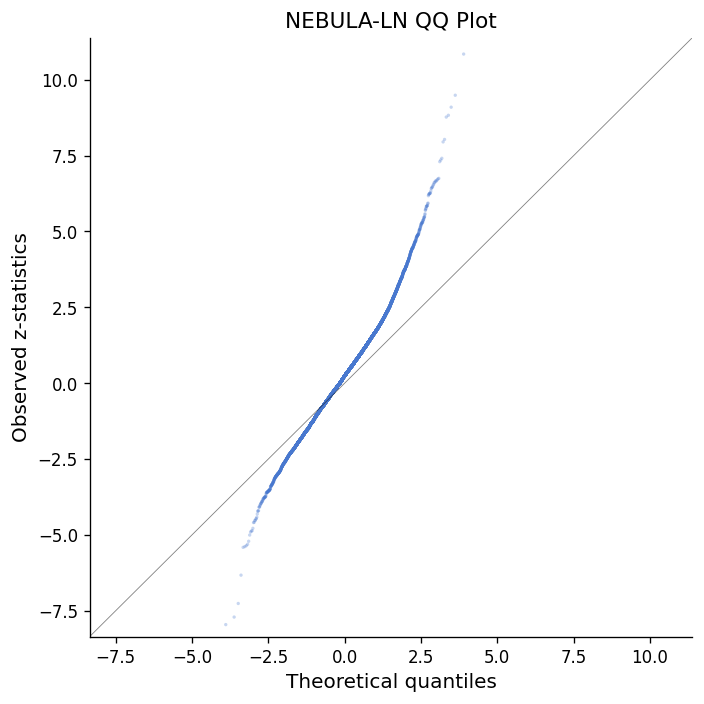

Number of z-statistics: 10,285


In [6]:
from scipy.stats import norm

conv = fit['convergence'] == 1
z_vals = fit['coefficients'][conv, 1] / fit['se'][conv, 1]
z_vals = z_vals[np.isfinite(z_vals)]

n_z = len(z_vals)
theoretical = norm.ppf((np.arange(1, n_z + 1) - 0.5) / n_z)
observed = np.sort(z_vals)

fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(theoretical, observed, c=BLUE, s=4, alpha=0.3, edgecolors='none',
           rasterized=True)
lims = [min(theoretical.min(), observed.min()) * 1.05,
        max(theoretical.max(), observed.max()) * 1.05]
ax.plot(lims, lims, 'k-', lw=0.5, alpha=0.5)
ax.set_xlim(lims); ax.set_ylim(lims)
ax.set_xlabel('Theoretical quantiles')
ax.set_ylabel('Observed z-statistics')
ax.set_title('NEBULA-LN QQ Plot')
plt.tight_layout()
plt.show()

print(f'Number of z-statistics: {n_z:,}')

## 5. Cell-Level BCV Plot

The biological coefficient of variation (BCV) is the square root of the dispersion parameter. This plot shows the per-gene maximum likelihood dispersion estimates and the empirical Bayes prior trend as a function of gene abundance.

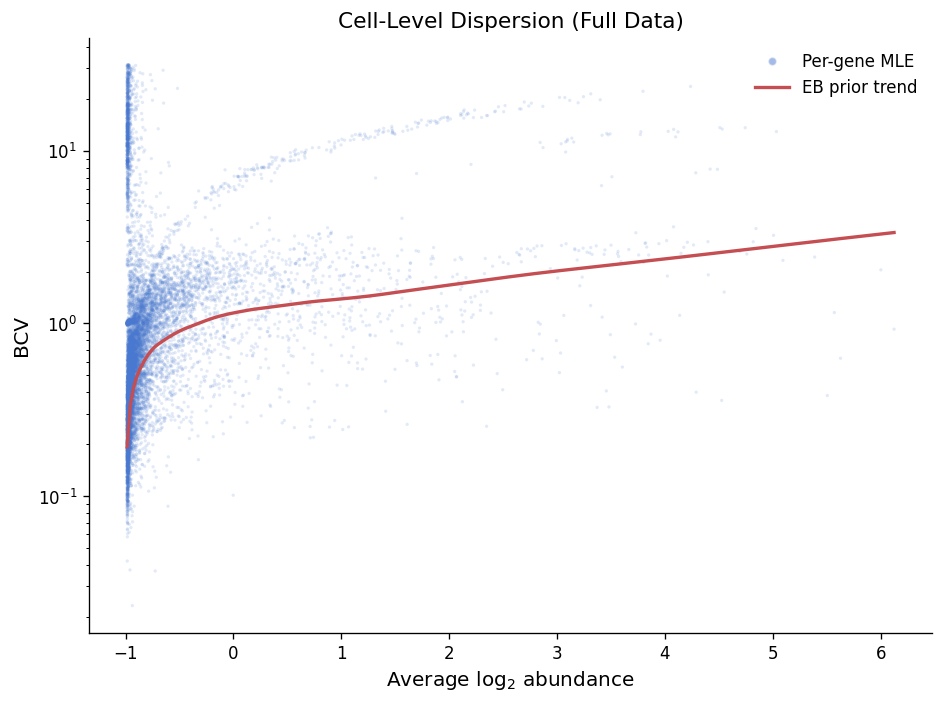

Genes plotted: 10,222


In [7]:
phi_raw = fit['phi_raw']
abund = fit['ave_log_abundance']
ok = conv & np.isfinite(phi_raw) & (phi_raw > 0) & (phi_raw < 999)
abund_ok = abund[ok]
bcv_raw = np.sqrt(phi_raw[ok])

fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(abund_ok, bcv_raw, c=BLUE, s=4, alpha=0.15, edgecolors='none',
           rasterized=True)

phi_prior = fit['phi_prior'][ok]
order = np.argsort(abund_ok)
ax.plot(abund_ok[order], np.sqrt(phi_prior[order]), color=RED,
        lw=2.0, label='EB prior trend', zorder=5)

ax.set_yscale('log')
ax.set_xlabel('Average log$_2$ abundance')
ax.set_ylabel('BCV')
ax.set_title('Cell-Level Dispersion (Full Data)')
legend_elements = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor=BLUE,
           markersize=5, alpha=0.5, label='Per-gene MLE'),
    Line2D([0], [0], color=RED, lw=2.0, label='EB prior trend'),
]
ax.legend(handles=legend_elements, frameon=False)
plt.tight_layout()
plt.show()

print(f'Genes plotted: {ok.sum():,}')

## 6. Differential Expression: Fed vs Starved

We test the `fed` coefficient using the Wald test via `top_tags`.

In [8]:
# Attach gene names
gene_mask = fit['gene_mask']
if fit['genes'] is None:
    fit['genes'] = pd.DataFrame({'gene': raw_gene_names[gene_mask]})

n_genes = fit['coefficients'].shape[0]
tt = ep.top_tags(fit, n=n_genes, coef='fed')
table = tt['table']

n_sig = (table['FDR'] < 0.05).sum()
n_up = ((table['FDR'] < 0.05) & (table['logFC'] > 0)).sum()
n_down = ((table['FDR'] < 0.05) & (table['logFC'] < 0)).sum()
print(f'Genes tested: {len(table):,}')
print(f'DE at FDR < 0.05: {n_sig} ({n_up} up in fed, {n_down} down in fed)')
print()
print('Top 20 DE genes:')
table.head(20)

Genes tested: 10,377
DE at FDR < 0.05: 689 (524 up in fed, 165 down in fed)

Top 20 DE genes:


,gene,logFC,SE,z,PValue,FDR
10287,XLOC_045480,1.473719,0.135827,10.849991,1.994451e-27,2.069641e-23
3388,XLOC_011294,0.679634,0.071599,9.492252,2.260961e-21,1.173100e-17
9661,XLOC_043270,0.414579,0.045566,9.098383,9.168643e-20,3.171434e-16
6193,XLOC_030052,0.704744,0.079799,8.831439,1.033373e-18,2.680829e-15
2368,XLOC_007747,1.608403,0.183355,8.772073,1.754062e-18,3.640379e-15
7697,XLOC_035885,0.407564,0.050724,8.035018,9.356523e-16,1.618211e-12
3278,XLOC_010859,-0.448499,0.056338,-7.960911,1.707778e-15,2.347707e-12
112,XLOC_000300,0.365625,0.045969,7.953720,1.809931e-15,2.347707e-12
8924,XLOC_040487,-0.343887,0.044586,-7.712943,1.229494e-14,1.417606e-11
7410,XLOC_034593,0.207443,0.027982,7.413358,1.231411e-13,1.277836e-10


## 7. Volcano Plot

Log-fold-change vs significance, with genes significant at FDR < 0.05 highlighted in red.

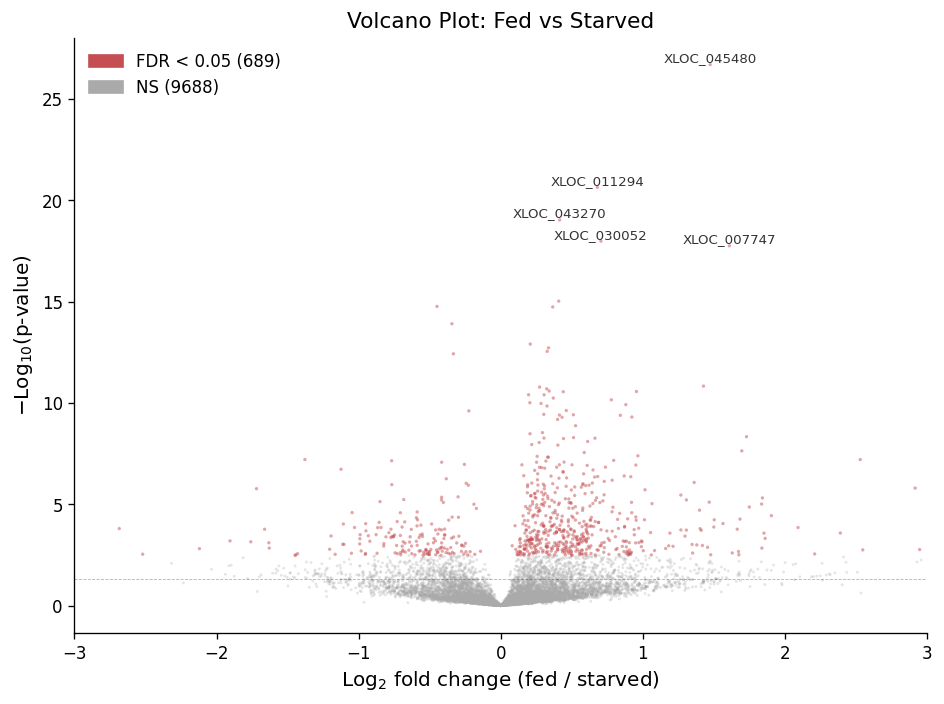

In [9]:
logfc = table['logFC'].values
logp = -np.log10(table['PValue'].values + 1e-300)
fdr = table['FDR'].values
sig = fdr < 0.05

fc_lim = max(np.percentile(np.abs(logfc), 99.5), 3.0)
fc_lim = min(fc_lim, 5.0)

fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(logfc[~sig], logp[~sig], c=GREY, s=3, alpha=0.3,
           edgecolors='none', rasterized=True)
ax.scatter(logfc[sig], logp[sig], c=RED, s=4, alpha=0.5,
           edgecolors='none', rasterized=True)

# Label top 5 genes
for idx in table.head(5).index:
    row = table.loc[idx]
    gene = row.get('gene', str(idx))
    if len(gene) > 15:
        gene = gene[:12] + '...'
    fc_val = row['logFC']
    pval = -np.log10(row['PValue'] + 1e-300)
    fc_plot = np.clip(fc_val, -fc_lim * 0.95, fc_lim * 0.95)
    ax.annotate(gene, (fc_plot, pval), fontsize=8, alpha=0.8,
                ha='center', va='bottom')

ax.set_xlim(-fc_lim, fc_lim)
ax.set_xlabel('Log$_2$ fold change (fed / starved)')
ax.set_ylabel('$-$Log$_{10}$(p-value)')
ax.set_title('Volcano Plot: Fed vs Starved')
ax.axhline(-np.log10(0.05), color='k', ls='--', lw=0.5, alpha=0.3)

handles = [mpatches.Patch(color=RED, label=f'FDR < 0.05 ({n_sig})'),
           mpatches.Patch(color=GREY, label=f'NS ({len(table) - n_sig})')]
ax.legend(handles=handles, frameon=False)
plt.tight_layout()
plt.show()

## 8. Empirical Bayes Shrinkage Effect

To illustrate the effect of shrinkage, we subsample 30 cells and refit the model. With so few cells, the per-gene MLE dispersions are very noisy. Empirical Bayes shrinkage pulls these estimates toward an abundance-dependent prior trend, producing more stable posterior estimates.

In [10]:
n_sub = 30
rng = np.random.RandomState(42)
idx_sub = rng.choice(n_gastro, size=n_sub, replace=False)
idx_sub.sort()

counts_sub = counts_T[:, idx_sub]
design_sub = design.iloc[idx_sub].reset_index(drop=True)
org_sub = org_gastro[idx_sub]

print(f'Fitting subsampled model ({n_sub} cells)...', flush=True)
t0 = time.perf_counter()
fit_sub = ep.glm_sc_fit(counts_sub, design=design_sub, sample=org_sub,
                         norm_method='TMM', verbose=False)
print(f'Fit in {time.perf_counter()-t0:.1f}s')
fit_sub = ep.shrink_sc_disp(fit_sub, robust=True)

n_conv_sub = (fit_sub['convergence'] == 1).sum()
n_total_sub = len(fit_sub['convergence'])
print(f'Genes: {n_total_sub:,}, converged: {n_conv_sub:,}')

Fitting subsampled model (30 cells)...


/Users/lpachter/Dropbox/claude/projects/edgestar/upload/edgepython/normalization.py:181: UserWarning: One or more quantiles are zero
  warnings.warn("One or more quantiles are zero")


Fit in 1.1s
Genes: 1,605, converged: 1,602


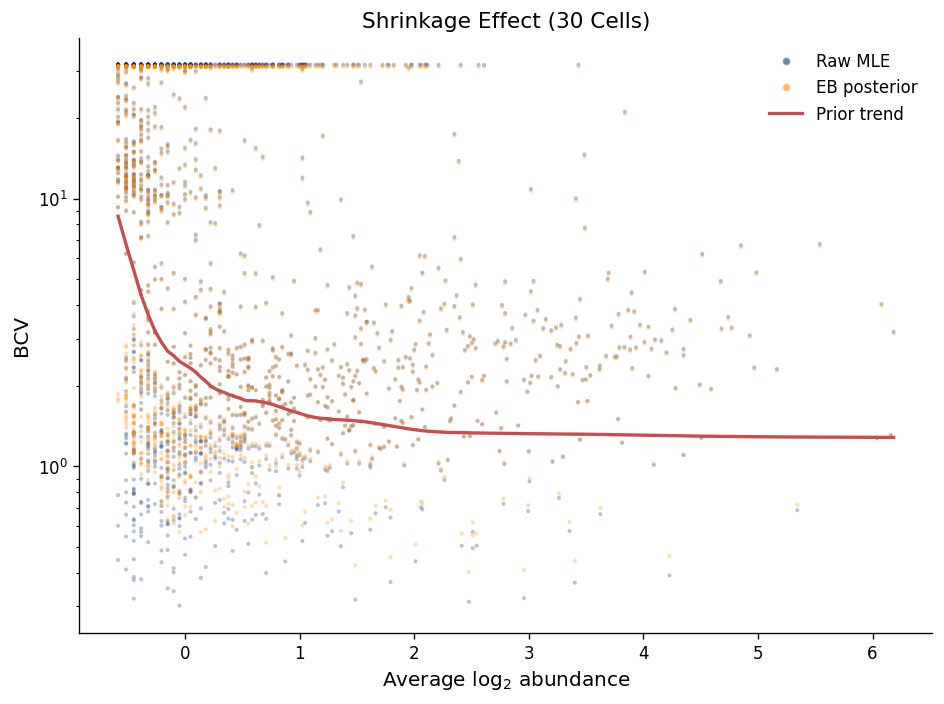

Genes plotted: 1,602


In [11]:
conv_s = fit_sub['convergence'] == 1
phi_raw_s = fit_sub['phi_raw']
phi_post_s = fit_sub['phi_post']
abund_s = fit_sub['ave_log_abundance']
ok_s = conv_s & np.isfinite(phi_raw_s) & (phi_raw_s > 0)
ok_s = ok_s & np.isfinite(phi_post_s) & (phi_post_s > 0)
abund_s_ok = abund_s[ok_s]

BLUE_DARK = '#1a3670'
ORANGE_BRIGHT = '#ff8c00'

fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(abund_s_ok, np.sqrt(phi_raw_s[ok_s]), c=BLUE_DARK, s=6, alpha=0.3,
           edgecolors='none', rasterized=True, zorder=2)
ax.scatter(abund_s_ok, np.sqrt(phi_post_s[ok_s]), c=ORANGE_BRIGHT, s=6, alpha=0.3,
           edgecolors='none', rasterized=True, zorder=3)

phi_prior_s = fit_sub['phi_prior'][ok_s]
order_s = np.argsort(abund_s_ok)
ax.plot(abund_s_ok[order_s], np.sqrt(phi_prior_s[order_s]), color=RED,
        lw=2.0, zorder=5)

ax.set_yscale('log')
ax.set_xlabel('Average log$_2$ abundance')
ax.set_ylabel('BCV')
ax.set_title(f'Shrinkage Effect ({n_sub} Cells)')
legend_elements = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor=BLUE_DARK,
           markersize=5, alpha=0.6, label='Raw MLE'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor=ORANGE_BRIGHT,
           markersize=5, alpha=0.6, label='EB posterior'),
    Line2D([0], [0], color=RED, lw=2.0, label='Prior trend'),
]
ax.legend(handles=legend_elements, frameon=False)
plt.tight_layout()
plt.show()

print(f'Genes plotted: {ok_s.sum():,}')

## 9. Combined Figure

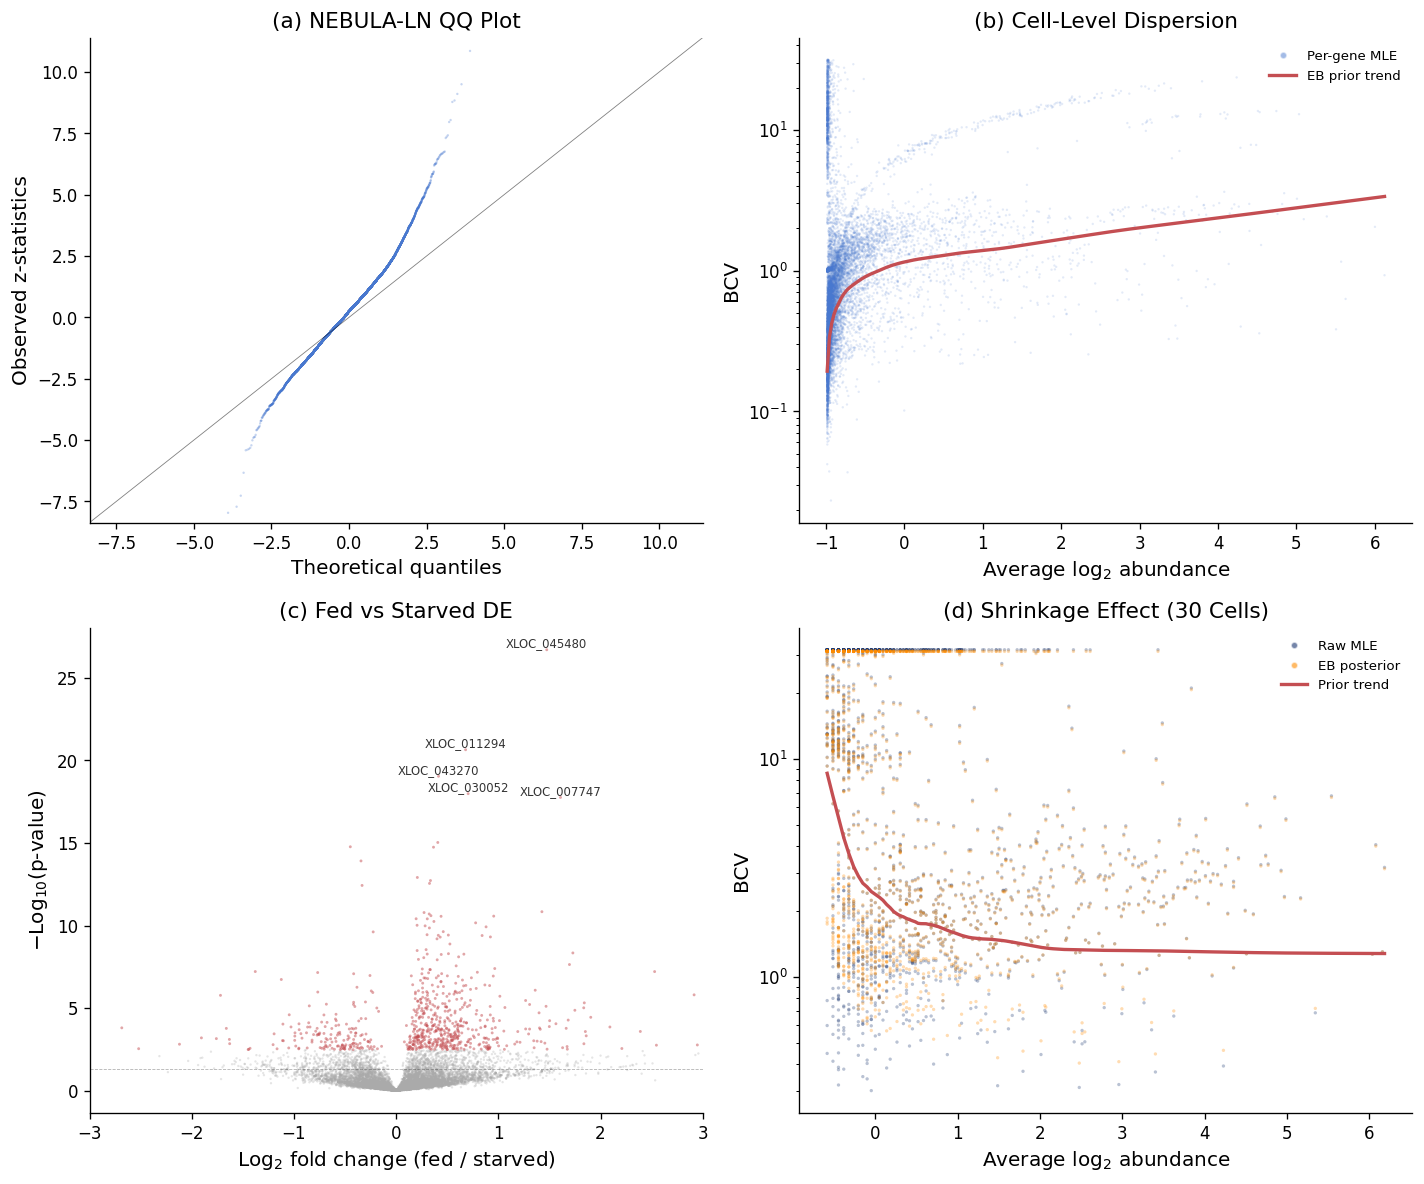

In [12]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# (a) QQ plot
ax = axes[0, 0]
ax.scatter(theoretical, observed, c=BLUE, s=2, alpha=0.3, edgecolors='none',
           rasterized=True)
ax.plot(lims, lims, 'k-', lw=0.5, alpha=0.5)
ax.set_xlim(lims); ax.set_ylim(lims)
ax.set_xlabel('Theoretical quantiles')
ax.set_ylabel('Observed z-statistics')
ax.set_title('(a) NEBULA-LN QQ Plot')

# (b) BCV plot
ax = axes[0, 1]
ax.scatter(abund_ok, bcv_raw, c=BLUE, s=2, alpha=0.15, edgecolors='none',
           rasterized=True)
ax.plot(abund_ok[order], np.sqrt(phi_prior[order]), color=RED,
        lw=2.0, zorder=5)
ax.set_yscale('log')
ax.set_xlabel('Average log$_2$ abundance')
ax.set_ylabel('BCV')
ax.set_title('(b) Cell-Level Dispersion')
legend_b = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor=BLUE,
           markersize=4, alpha=0.5, label='Per-gene MLE'),
    Line2D([0], [0], color=RED, lw=2.0, label='EB prior trend'),
]
ax.legend(handles=legend_b, fontsize=8, frameon=False)

# (c) Volcano plot
ax = axes[1, 0]
ax.scatter(logfc[~sig], logp[~sig], c=GREY, s=2, alpha=0.3,
           edgecolors='none', rasterized=True)
ax.scatter(logfc[sig], logp[sig], c=RED, s=3, alpha=0.5,
           edgecolors='none', rasterized=True)
for idx in table.head(5).index:
    row = table.loc[idx]
    gene = row.get('gene', str(idx))
    if len(gene) > 15:
        gene = gene[:12] + '...'
    fc_val = row['logFC']
    pval = -np.log10(row['PValue'] + 1e-300)
    fc_plot = np.clip(fc_val, -fc_lim * 0.95, fc_lim * 0.95)
    ax.annotate(gene, (fc_plot, pval), fontsize=7, alpha=0.8,
                ha='center', va='bottom')
ax.set_xlim(-fc_lim, fc_lim)
ax.set_xlabel('Log$_2$ fold change (fed / starved)')
ax.set_ylabel('$-$Log$_{10}$(p-value)')
ax.set_title('(c) Fed vs Starved DE')
ax.axhline(-np.log10(0.05), color='k', ls='--', lw=0.5, alpha=0.3)

# (d) Shrinkage
ax = axes[1, 1]
ax.scatter(abund_s_ok, np.sqrt(phi_raw_s[ok_s]), c=BLUE_DARK, s=4, alpha=0.3,
           edgecolors='none', rasterized=True, zorder=2)
ax.scatter(abund_s_ok, np.sqrt(phi_post_s[ok_s]), c=ORANGE_BRIGHT, s=4, alpha=0.3,
           edgecolors='none', rasterized=True, zorder=3)
ax.plot(abund_s_ok[order_s], np.sqrt(phi_prior_s[order_s]), color=RED,
        lw=2.0, zorder=5)
ax.set_yscale('log')
ax.set_xlabel('Average log$_2$ abundance')
ax.set_ylabel('BCV')
ax.set_title(f'(d) Shrinkage Effect ({n_sub} Cells)')
legend_d = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor=BLUE_DARK,
           markersize=4, alpha=0.6, label='Raw MLE'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor=ORANGE_BRIGHT,
           markersize=4, alpha=0.6, label='EB posterior'),
    Line2D([0], [0], color=RED, lw=2.0, label='Prior trend'),
]
ax.legend(handles=legend_d, fontsize=8, frameon=False)

plt.tight_layout()
plt.show()

## 10. Summary

In [13]:
summary = pd.DataFrame({
    'Statistic': [
        'Full dataset (cells x genes)',
        'GastroDigestive cells',
        'Organisms',
        'Genes tested (after filtering)',
        'Converged genes',
        'DE genes (FDR < 0.05)',
        'Up in fed',
        'Down in fed',
        'Model fitting time',
    ],
    'Value': [
        f'{n_obs:,} x {n_var_raw:,}',
        f'{n_gastro:,}',
        f'{len(np.unique(org_gastro))}',
        f'{n_total:,}',
        f'{n_converged:,}',
        f'{n_sig}',
        f'{n_up}',
        f'{n_down}',
        f'{t_fit:.1f}s',
    ]
})
summary

,Statistic,Value
0,Full dataset (cells x genes),"13,673 x 28,514"
1,GastroDigestive cells,"2,564"
2,Organisms,10
3,Genes tested (after filtering),"10,377"
4,Converged genes,"10,285"
5,DE genes (FDR < 0.05),689
6,Up in fed,524
7,Down in fed,165
8,Model fitting time,44.7s
